## Classifying IMDb Movie Data with K-Nearest Neighbors
##### By: Armando Acosta

Summary: This is a project that aims to practice K-Nearest Neighbors classification using parallel processing on a dataset provided by IMDb containing information such as a movie's genre, release date, actors, runtime, etc.

This project serves primarily as a way to practice implementing the KNN algorithm, and therefore does not perform any predictive analyses or more complex Machine Learning practices. However, more experiments may be performed using the results of the computations in this notebook if one so chooses to make even more complex models.

Dataset Reference and General Info: https://www.imdb.com/interfaces/

#### 1. Downloading Dependencies
We first start off with installing the mpi4py library in our local instance in order to make use and take advantage of parallel processing to handle our large amount of data during our algorithm calculation.

In [1]:
! pip install mpi4py


     |████████████████████████████████| 1.4MB 6.8MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp37-cp37m-linux_x86_64.whl size=2065179 sha256=199d5ecf94cb39337151a698595dc902b06d5f3e313bd3eb3e27517df00b4ea6
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py


#### 2. Importing and Building Directory
Next, we will ensure that we import the necessary libraries to perform our analyses and also verify we have the necessary data files in our directory. We can do this by examining the head of the created dataframe based off of a given file.

For this project, we will be using IMDb's following files in their dataset collection:

`title.basics.tsv`  
`title.ratings.tsv`  


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

BasicsDataFrame = pd.read_csv('title.basics.tsv', sep='\t')
RatingsDataFrame = pd.read_csv('title.ratings.tsv', sep='\t')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Things should have been read as intended; but let's check the first 5 (head) values of the dataframe of each dataset to check.

In [3]:
BasicsDataFrame.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [4]:
RatingsDataFrame.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1701
1,tt0000002,6.1,210
2,tt0000003,6.5,1458
3,tt0000004,6.1,123
4,tt0000005,6.1,2259


As expected, everything seems to have loaded just fine. So we can now move forward onto more experiments.

#### 3. Establishing the Attributes of Interest
With these files, we already have some interesting columns of data to look at. However, we will only use a select variety of these attributes to work with our K-Nearest Neighbor classification algorithm. The reason we choose these attributes is due in part to their nature of being able to be simply classified into certain labels and so we can easily perform predictive analysis with future experiments if we so choose.

The attributes we will use to calculate with are:  
- `genres`: the genre(s) the movie belongs to  
- `averageRating`: the average rating based off of users from IMDb  
- `runtimeMinutes`: the runtime (in minutes) of a film


#### 4. Plotting the Raw Data
So now that we have decided our approach for our algorithm, let's start off by creating a scatterplot of the raw data. We will create our plots with the number of votes as our dependent variable and the average rating acting as our response variable.


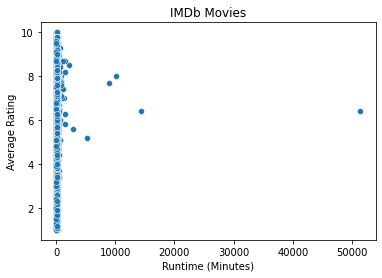

In [5]:
# Build a combined data frame
fullData = pd.merge(BasicsDataFrame, RatingsDataFrame, on=['tconst'])

# Remove any titles not released yet and television shows
fullData = fullData[fullData.startYear != '\\N']
fullData['startYear'] = pd.to_numeric(fullData['startYear'])
fullData = fullData[fullData.titleType == 'movie']

# Remove any titles with no runtime information
fullData = fullData[fullData.runtimeMinutes != '\\N']
fullData['runtimeMinutes'] = pd.to_numeric(fullData['runtimeMinutes'])

ax = sns.scatterplot(data=fullData, x='runtimeMinutes', y='averageRating')
plt.title('IMDb Movies - Runtime vs Rating')
plt.xlabel('Runtime (Minutes)')
plt.ylabel('Average Rating')

plt.show()


#### 5. Preprocessing
So it seems that we have some pretty extreme outliers throwing off our data visualization. So why don't we try performing some pre-processing to fix up our information before performing any algorithms.

First, let's start by getting rid of some entries. With over a million entries, it would be a bit hard to assess our algorithm, so let's focus on movies released in the last 10 years. Additionally, to take care of the outliers with extraordinary runtimes (more than 10,000 minutes), we will consider movies that are 5 hours or less (300 minutes).


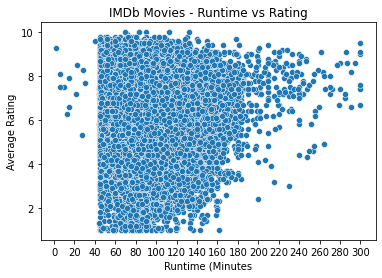

In [20]:
# Fetch only movies released after 2011
sampledData = fullData.loc[fullData['startYear'] >= 2011]

# Ignore unavailable formatting and movies longer than 300 minutes
sampledData = sampledData[sampledData.runtimeMinutes != '\\N']
sampledData['runtimeMinutes'] = pd.to_numeric(sampledData['runtimeMinutes'])
sampledData = sampledData[sampledData.runtimeMinutes <= 300]

# Removing movies with unidentified genres (we'll need this later)
sampledData = sampledData[sampledData.genres != '\\N']

ax = sns.scatterplot(data=sampledData, x='runtimeMinutes', y='averageRating')
plt.title('IMDb Movies - Runtime vs Rating')
plt.xlabel('Runtime (Minutes')
plt.ylabel('Average Rating')
plt.xticks(np.arange(0, max(sampledData['runtimeMinutes'])+1, step=20))

plt.show()


Looks much better. However, this is still way too many movies to see any proper clusters forming. So let's break it down even further. This collection of movies has decreased from 200,000 to 80,000. So let's examine a random sample of 100 movies instead for further visualization purposes.

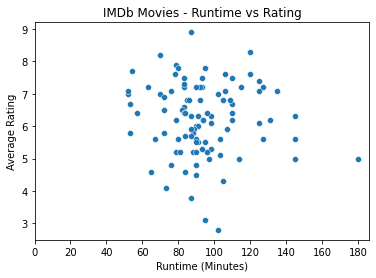

In [21]:
# We call 5 extra data points so those can be used as test points later
sampledData = sampledData.sample(n=105, random_state=2021-5-14)

testData = sampledData.iloc[:5]
sampledData = sampledData.iloc[5:]

ax = sns.scatterplot(data=sampledData, x='runtimeMinutes', y='averageRating')
plt.title('IMDb Movies - Runtime vs Rating')
plt.xlabel('Runtime (Minutes)')
plt.ylabel('Average Rating')
plt.xticks(np.arange(0, max(sampledData['runtimeMinutes'])+1, step=20))

plt.show()


That's much better. Now one last step before jumping into our algorithm; we are going to try and categorize each plot point with a color determining its genre.

The dataset provides each entry with the top 3 genres it is attributed to. However, to keep things simple, we will only consider each movies top, first genre that it is commonly attributed as. Then, we'll plot our scatterplot once more.


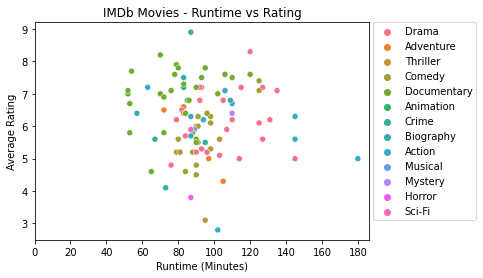

In [22]:
sampledData['genres'] = sampledData['genres'].str.split(',').str[0]

ax = sns.scatterplot(data=sampledData, x='runtimeMinutes', y='averageRating',
                     hue='genres')
plt.title('IMDb Movies - Runtime vs Rating')
plt.xlabel('Runtime (Minutes)')
plt.ylabel('Average Rating')
plt.xticks(np.arange(0, max(sampledData['runtimeMinutes'])+1, step=20))
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)

plt.show()


#### 6. Performing the KNN Algorithm
We now continue to the main focus of our project where we perform the K-Nearest Neighbor algorithm where we attempt to predict each individual data point's movie genre.

Unfortunately, we have no way of directly implementing MPI within the notebook we have going. So we will have to come up with a bit of a work-around.

First, we are going to convert our dataframe of information to test with to a csv file. From there, we will run the typical MPI directives on a separate script we have prepared with the implemented algorithm methods. This information will then be saved into another csv with the results of our algorithm.


In [14]:
sampledData.to_csv(path_or_buf='sampled_data.csv')
testData.to_csv(path_or_buf='test_data.csv')

! mpirun --allow-run-as-root -n 100 python knn.py


After running the command, we'll find that our `test_data.csv` was modified successfully and our algorithm has attempted to predict a movie's genre based off the proximity of its neighbors.

While we can simply go down the list and compare the results, we should perform one last visualization experiment and create a confusion matrix to see how the results fared.


In [32]:
testPredictions = pd.read_csv(filepath_or_buffer='test_data.csv')

# Set the genres of the original test set
testData['genres'] = testData['genres'].str.split(',').str[0]

print('Predicted genres:', testPredictions['genres'].values)
print('Actual genres:', testData['genres'].values)

pd.crosstab(testData['genres'].values, testPredictions['genres'].values,
            rownames=['True'], colnames=['Predicted'], margins=True)


Predicted genres: ['Comedy' 'Drama' 'Documentary' 'Documentary' 'Documentary']
Actual genres: ['Documentary' 'Action' 'Drama' 'Sport' 'Documentary']


Predicted,Comedy,Documentary,Drama,All
True,,,,
Action,0,0,1,1
Documentary,1,1,0,2
Drama,0,1,0,1
Sport,0,1,0,1
All,1,3,1,5


## Summary and Closing Thoughts
So, as expected, our model had a relatively poor performance. Given the fact that there was only one true positive prediction, it could be safe to say  this model is not the most sound for predicting a movie's genre.

However, we DID only test it on 5 data points. Therefore, the notion of accuracy could change drastically if were to test it on more entries. Additionally, we only checked against 100 movies as our sample space. Could we possibly see an even better performance if we have more data to work with?

These questions would certainly be interesting experiments to perform -- but as mentioned, our focus here was to simply implement the KNN algorithm using parallel processing. Therefore, we leave our experiment today with the insight that predicting a movie's genre solely based on its runtime and performance could be a bit of a vague task to undertake. But perhaps with some more tweaking and analyses, we could reach a point of accurately predicting just what type of movie it is a viewer may be watching based on some simple metrics.
